In [56]:
%matplotlib inline

import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor

# Obtendo dados 

In [24]:
HEART_PATH = os.path.join("datasets")

# Carregando dados
def load_housing_data(heart_path=HEART_PATH):
    csv_path = os.path.join(heart_path, "heart.csv")
    return pd.read_csv(csv_path)

heart = load_housing_data()

# Análise exploratória
### Obtendo detalhes do dataframe

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Descrição das Colunas do Dataset
### Abaixo uma pequena introdução às variáveis em ingles e seus significados

| **Coluna**          | **Descrição**                                                                 |
|----------------------|-------------------------------------------------------------------------------|
| **Age**             | Idade da pessoa (em anos).                                                   |
| **Sex**             | Sexo da pessoa. Valores:                                                     |
|                      | - "M" para Masculino                                                        |
|                      | - "F" para Feminino                                                         |
| **ChestPainType**    | Tipo de dor no peito. Valores possíveis:                                     |
|                      | - "ATA": Angina Típica                                                     |
|                      | - "NAP": Angina Atípica                                                    |
|                      | - "ASY": Assintomático                                                     |
|                      | - "TA": Angina Transitória                                                 |
| **RestingBP**        | Pressão arterial em repouso (mmHg).                                          |
| **Cholesterol**      | Nível de colesterol sérico (mg/dl).                                          |
| **FastingBS**        | Glicemia de jejum. Valores:                                                 |
|                      | - 1 se glicemia ≥ 120 mg/dl                                                 |
|                      | - 0 caso contrário                                                          |
| **RestingECG**       | Resultado do eletrocardiograma em repouso. Valores:                         |
|                      | - "Normal"                                                                 |
|                      | - "ST": Anomalias de onda ST/T                                             |
|                      | - "LVH": Hipertrofia ventricular esquerda                                  |
| **MaxHR**            | Frequência cardíaca máxima atingida.                                        |
| **ExerciseAngina**   | Angina induzida por exercício. Valores:                                     |
|                      | - "Y" para Sim                                                             |
|                      | - "N" para Não                                                             |
| **Oldpeak**          | Depressão do segmento ST induzida por exercício em relação ao repouso.       |
| **ST_Slope**         | Inclinação do segmento ST durante o exercício. Valores:                     |
|                      | - "Up": Ascendente                                                        |
|                      | - "Flat": Plana                                                           |
|                      | - "Down": Descendente                                                     |
| **HeartDisease**     | Diagnóstico de doença cardíaca. Valores:                                    |
|                      | - 1 para presença de doença cardíaca                                       |
|                      | - 0 para ausência de doença cardíaca                                       |


In [4]:
# Obtendo uma descrição dos dados
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# Obtendo um resumo dos dados numéricos
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Explorando os atributos categóricos

In [7]:
# Sexo dos pacientes
heart["Sex"].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64

In [8]:
# Tipo de dor no peito
heart["ChestPainType"].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [9]:
# Resultados do eletrocardiograma em repouso
heart["RestingECG"].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [10]:
# Angina induzida por exercício
heart["ExerciseAngina"].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [11]:
# Inclinação do pico do segmento ST em exercício
heart["ST_Slope"].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

# Visualizando os dados

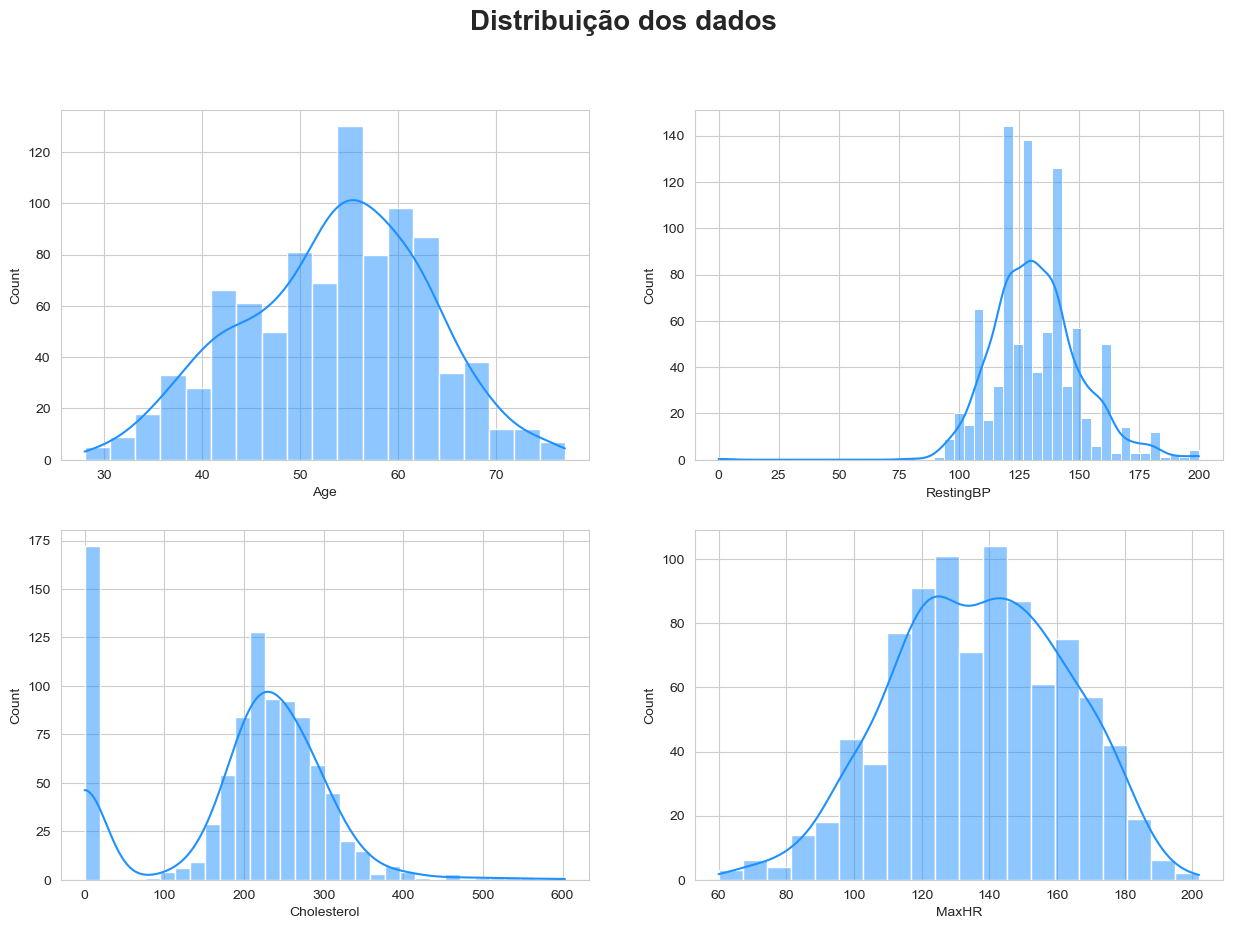

In [12]:
heart_vis = heart.drop(columns=["FastingBS", "HeartDisease"])

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data=heart_vis, x="Age", kde=True, color="dodgerblue", ax=axs[0, 0])
sns.histplot(data=heart_vis, x="RestingBP", kde=True, color="dodgerblue", ax=axs[0, 1])
sns.histplot(data=heart_vis, x="Cholesterol", kde=True, color="dodgerblue", ax=axs[1, 0])
sns.histplot(data=heart_vis, x="MaxHR", kde=True, color="dodgerblue", ax=axs[1, 1])

fig.suptitle('Distribuição dos dados', fontsize=20, fontweight='bold')
plt.show();

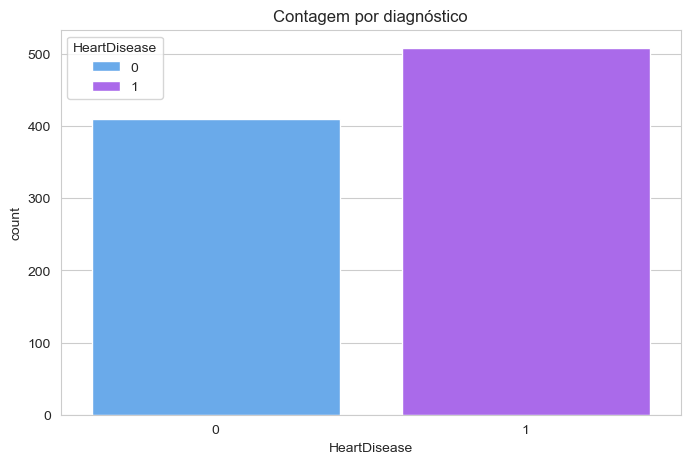

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(x="HeartDisease", data=heart, hue="HeartDisease", palette="cool")
plt.title("Contagem por diagnóstico")
plt.show();

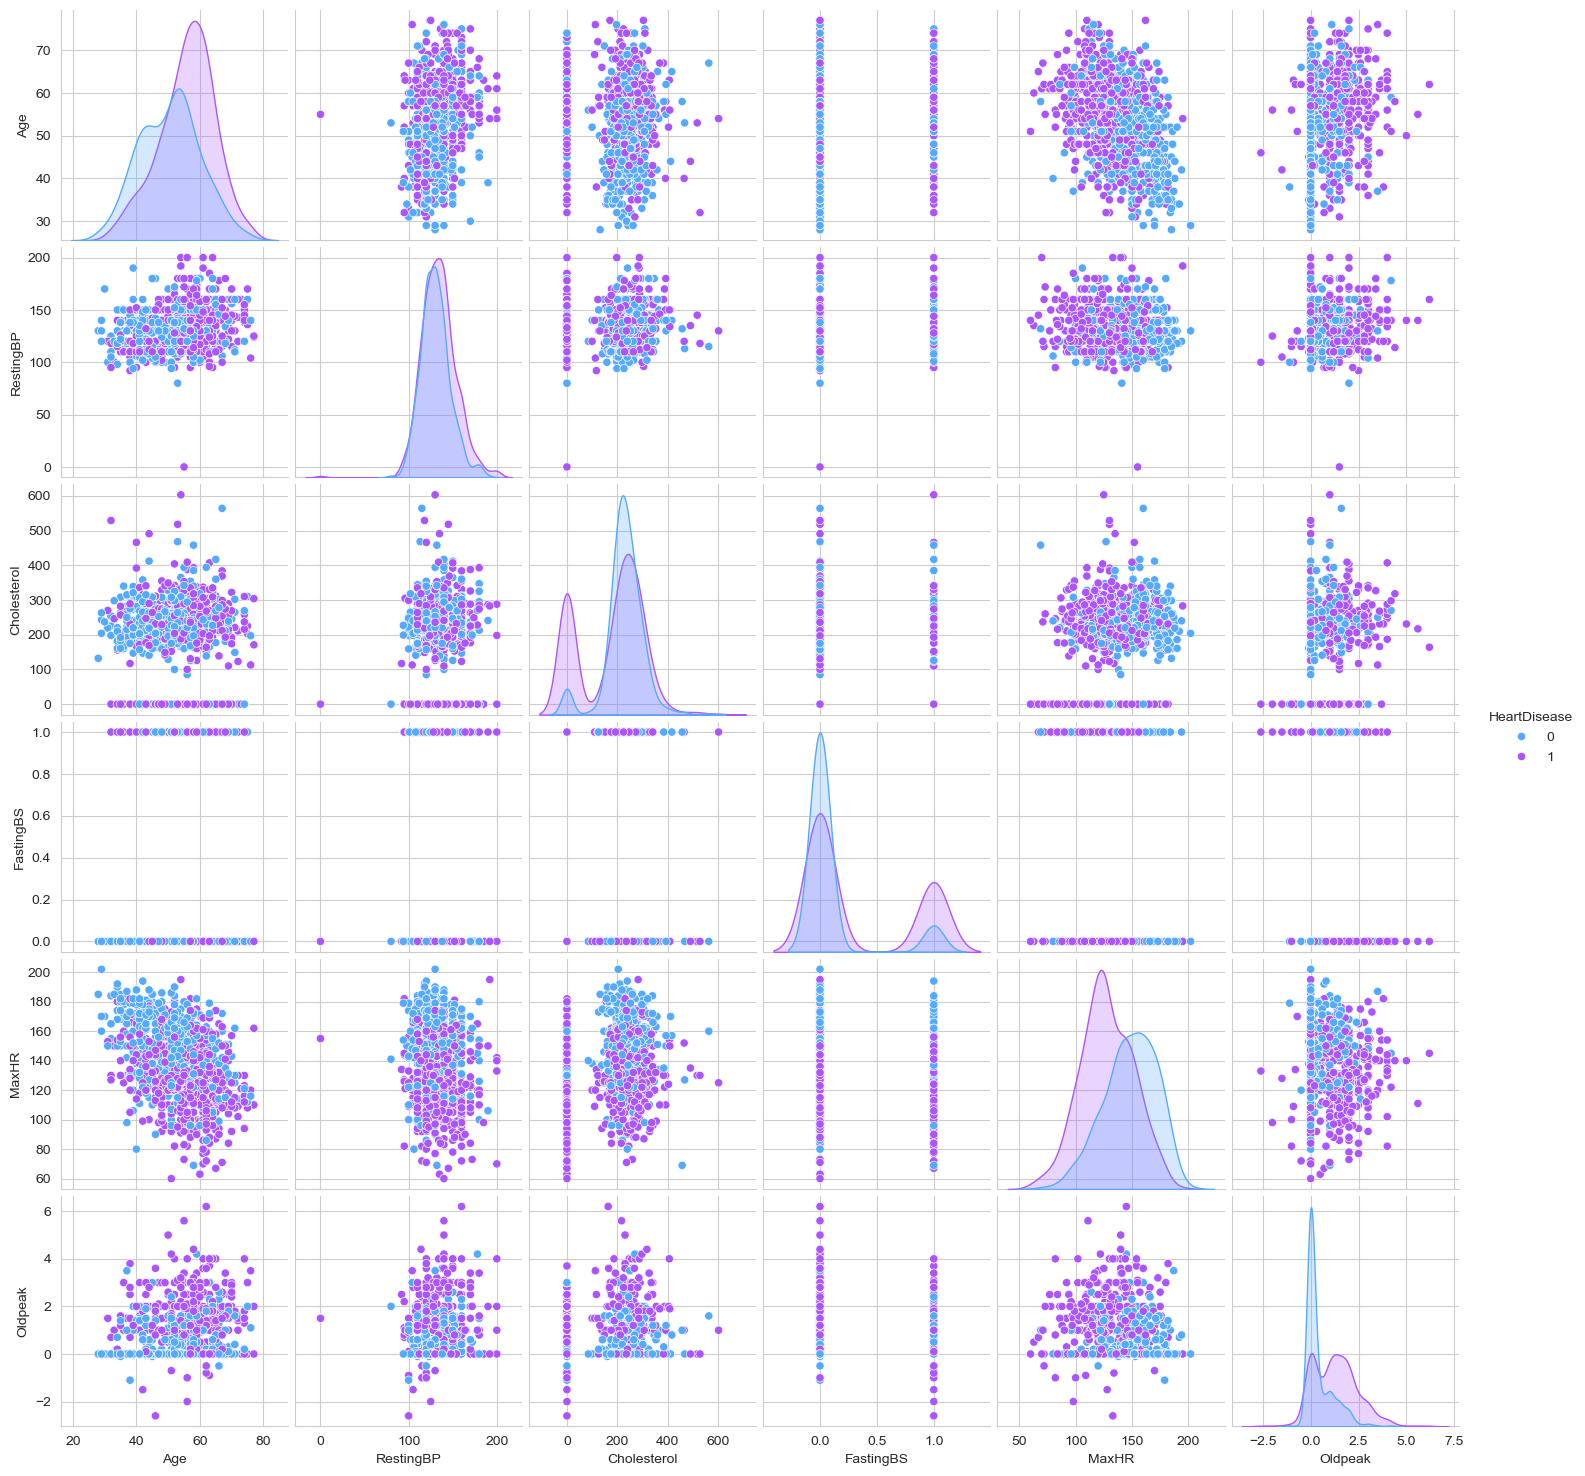

In [14]:
sns.pairplot(heart, diag_kind="kde", hue="HeartDisease", palette='cool')
plt.show();

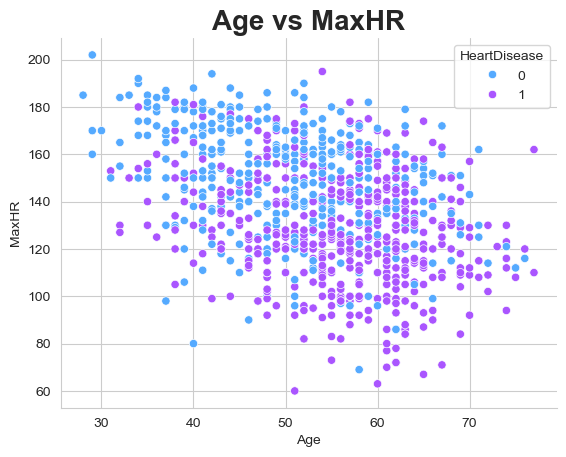

In [15]:
sns.scatterplot(x="Age", y="MaxHR", hue="HeartDisease", data=heart, palette="cool")
sns.despine()
plt.title("Age vs MaxHR", fontsize=20, fontweight="bold")
plt.show();

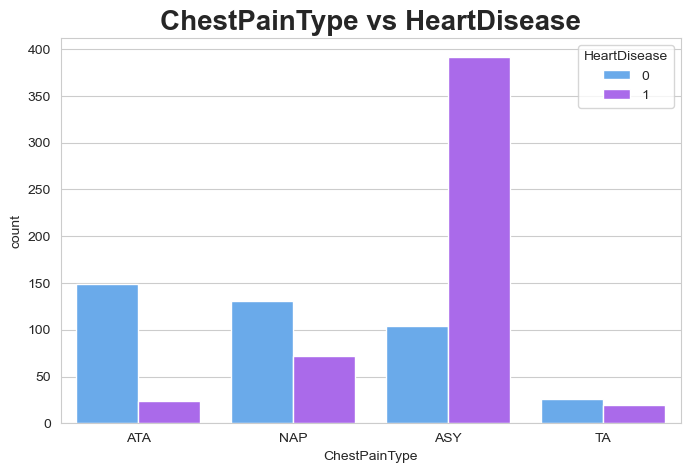

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x="ChestPainType", hue="HeartDisease", data=heart, palette="cool")
plt.title("ChestPainType vs HeartDisease", fontsize=20, fontweight="bold")
plt.show();

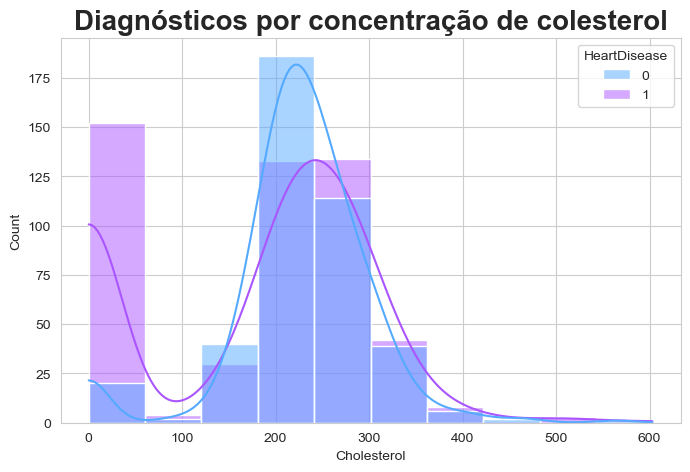

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data=heart, x="Cholesterol", hue="HeartDisease", kde=True, palette='cool', bins=10)
plt.title("Diagnósticos por concentração de colesterol", fontsize=20, fontweight="bold")
plt.show();

# Criando o conjunto de testes

In [18]:
train_set, test_set = train_test_split(heart, test_size=0.2, random_state=42)

print("Treinamento: ", train_set.size)
print("Teste: ", test_set.size)

Treinamento:  8808
Teste:  2208


### Divisão Estratificada

Quando um modelo treina sobre um conjunto com uma amostragem de rótulos desequilibrada, ele pode acabar aprendendo de forma enviesada.

Para evitar isso, vamos separar o conjunto de treinamento e testes com uma amostragem equilibrada de ocorrencias de doença cardíaca (HeartDisease).

In [25]:
def stratified_split():
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

    # Vamos usar a coluna Sex para criar um amostragem equilibrada
    for train_indices, test_indices in split.split(heart, heart["HeartDisease"]):
        strat_train_set = heart.loc[train_indices]
        strat_test_set = heart.loc[test_indices]
        
        return strat_train_set, strat_test_set


strat_train_set, strat_test_set = stratified_split()
heart = strat_train_set.copy()

# Obtendo correlações entre os dados

In [20]:
# Obter a matriz de correlações
corr_matrix = heart.corr(numeric_only=True)
corr_matrix["HeartDisease"].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.376603
FastingBS       0.261391
Age             0.244689
RestingBP       0.102055
Cholesterol    -0.241413
MaxHR          -0.407227
Name: HeartDisease, dtype: float64

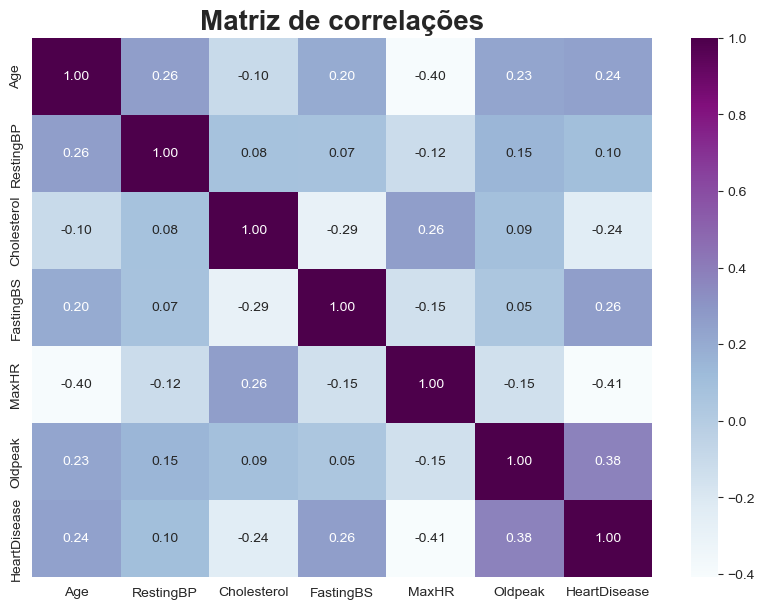

In [53]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='BuPu')
plt.title('Matriz de correlações', fontsize=20, fontweight='bold')
plt.show();

# Observações
Através da matriz de correlação podemos notar uma boa correlação entre HeartDisease e OldPeak. 

Outra boa correlação está entre HeartDisease e MaxHR (inversamente proporcional).

Vamos analisar essas relações mais perto.

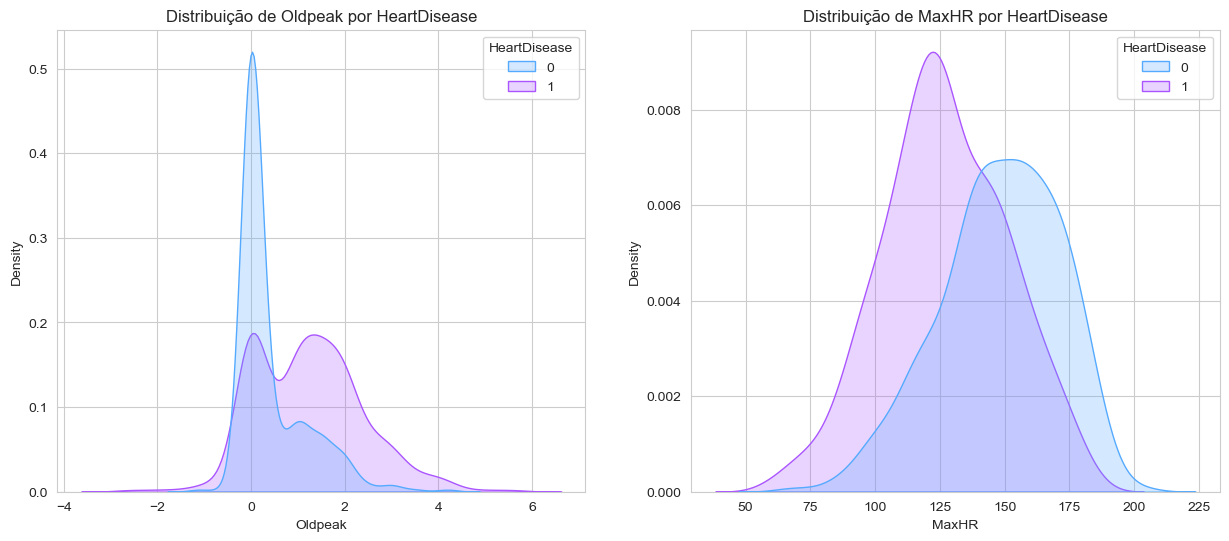

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=heart, x="Oldpeak", hue="HeartDisease", palette='cool', fill=True, ax=axes[0])
axes[0].set_title("Distribuição de Oldpeak por HeartDisease")

sns.kdeplot(data=heart, x="MaxHR", hue="HeartDisease", palette='cool', fill=True, ax=axes[1])
axes[1].set_title("Distribuição de MaxHR por HeartDisease")
plt.show();

# Preparando os dados para o treinamento
Inicialmente, vamos separar a coluna de rótulos das colunas de features.

In [72]:
label_columns = ["HeartDisease"]

heart = strat_train_set.drop(label_columns, axis=1)

# temos que usar o ravel para deixar heart_labels como um array unidimensional
heart_labels = strat_train_set[label_columns[0]].copy()
type(heart_labels)

pandas.core.series.Series

### Limpando os dados

In [73]:
# Função para separar as colunas categóricas das numéricas
def split_data(data, label_columns=label_columns):
    feature_columns = [c for c in data.columns if not c in label_columns]
    numeric_columns = []
    categorical_columns = []

    for c in feature_columns:
        if data[c].dtype == "object":
            categorical_columns.append(c)
        else:
            numeric_columns.append(c)

    return data[numeric_columns], data[categorical_columns]


heart_num, heart_cat = split_data(heart)

### Pipelines de pré processamento
Para manter o fluxo de pré-processamento e treinamento dos nossos modelos sempre consistente, vamos automatizar as transformações dos dados com Pipelines.

In [74]:
# pipeline para pré-processamento das variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # garantir que não haverá valores nulos 
    ('std_scaler', StandardScaler()),
])

# pipeline para pré-processamento das variáveis categóricas
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder())
])

# Compondo os pré-processadores
preprocessor = ColumnTransformer([
    ("num", num_pipeline, list(heart_num)),
    ("cat", OneHotEncoder(), list(heart_cat)),
])

# criando o modelo usando pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', RandomForestRegressor(random_state=42))
])

### Implementando GridSearch para descobrir o melhor estimador

In [79]:
# Como o modelo de Floresta Aleatória está em um pipeline, o grid search não tem como adiivinhar para quem são esses parametros
# Logo, temos que colocar o prefixo tree__
param_grid = [
    # Tenta 12 (4x4) combinações de hiperparâmetros
    {'tree__n_estimators': [3, 10, 30, 60], 'tree__max_features': [2, 4, 6, 8]},
    # Depois tenta 6 (2x3) combinações com bootstrap setado em False
    {'tree__bootstrap': [False], 'tree__n_estimators': [3, 10], 'tree__max_features': [2, 3, 4]},
]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=kfold, 
    scoring='neg_mean_squared_error',
  	return_train_score=True,
)

grid.fit(heart, heart_labels)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope'])])),
                                       ('tree',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'tree__max_features': [2, 4, 6, 8],
                          'tree__n_estimators': [3, 10, 30, 60]},
                         {'tree__bootstrap': [False],
                          'tree__max_features': [2, 3, 4],
                          'tree__n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [88]:
# Exibindo como ficaram os dados após as transformações
preprocessor = model.named_steps['preprocessor']
transformed_data = preprocessor.fit_transform(heart)
transformed_data[0]

array([ 0.9700116 ,  0.3390158 ,  0.12713661,  1.83549656, -0.32451998,
        0.31704567,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ])

In [80]:
# Exibindo a melhor configuração
grid.best_params_

{'tree__max_features': 2, 'tree__n_estimators': 60}

In [82]:
# Imprimindo os resultados de cada configuração
cvres = grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    # Negativa da MSE
    print(np.sqrt(-mean_score), params)

0.3785926590066587 {'tree__max_features': 2, 'tree__n_estimators': 3}
0.3385462295306223 {'tree__max_features': 2, 'tree__n_estimators': 10}
0.3296166383204825 {'tree__max_features': 2, 'tree__n_estimators': 30}
0.3217285812104589 {'tree__max_features': 2, 'tree__n_estimators': 60}
0.38076479399726215 {'tree__max_features': 4, 'tree__n_estimators': 3}
0.34392527681197393 {'tree__max_features': 4, 'tree__n_estimators': 10}
0.3290927730008483 {'tree__max_features': 4, 'tree__n_estimators': 30}
0.32621553224625366 {'tree__max_features': 4, 'tree__n_estimators': 60}
0.3975262347847949 {'tree__max_features': 6, 'tree__n_estimators': 3}
0.3429806529002887 {'tree__max_features': 6, 'tree__n_estimators': 10}
0.3308755411289436 {'tree__max_features': 6, 'tree__n_estimators': 30}
0.3281311198095186 {'tree__max_features': 6, 'tree__n_estimators': 60}
0.38157022088045744 {'tree__max_features': 8, 'tree__n_estimators': 3}
0.3443589363824366 {'tree__max_features': 8, 'tree__n_estimators': 10}
0.3296